In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create figures directory
Path('figures').mkdir(exist_ok=True)

# Import PeakWeather dataset
from peakweather import PeakWeatherDataset

In [24]:
dataset = PeakWeatherDataset(
    root='./PeakWeatherDataset',
    freq='h',
    station_type='meteo_station',
    extended_nwp_vars=['temperature'],  # Load ICON data for temperature
    extended_topo_vars='all'
)

print(f"Available stations: {len(dataset.stations_table)}")
print(f"Available parameters: {dataset.parameters_table}")
print(f"Available ICON data: {dataset.available_icon}")

Available stations: 160
Available parameters:                 param_id param_short  param_group_id param_group_name_E unit  \
name                                                                           
humidity              98    ure200s0               3           humidity    %   
precipitation         93    rre150z0               5      precipitation   mm   
pressure              90    prestas0               4           pressure  hPa   
sunshine              94    sre000z0               6           sunshine  min   
temperature           91    tre200s0               2        temperature   °C   
wind_direction       197    dkl010z0               1               wind    °   
wind_gust            101    fkl010z1               1               wind  m/s   
wind_speed           196    fkl010z0               1               wind  m/s   
wind_u               196  fkl010z0_u               1               wind  m/s   
wind_v               196  fkl010z0_v               1               wind  m

In [43]:
# Get all available meteorological data for sample stations
stations_sample = dataset.stations_table.index[10:15].tolist()
print(f"Analyzing stations: {stations_sample}")

# Get all available parameters for comprehensive analysis
all_params = dataset.parameters.tolist()
print(f"Loading parameters: {all_params}")

df, mask = dataset.get_observations(
    stations=stations_sample,
    parameters=all_params,  # Load all available parameters
    first_date='2023-01-01',
    last_date='2024-06-30',
    return_mask=True
)

print(f"\n=== Dataset Shape ===")
print(f"Shape: {df.shape}")
print(f"Time range: {df.index[0]} to {df.index[-1]}")
print(f"Total hours: {len(df)}")

Analyzing stations: ['BAS', 'BEH', 'BER', 'BEZ', 'BIA']
Loading parameters: ['humidity', 'precipitation', 'pressure', 'sunshine', 'temperature', 'wind_direction', 'wind_gust', 'wind_speed', 'wind_u', 'wind_v']

=== Dataset Shape ===
Shape: (13104, 50)
Time range: 2023-01-01 00:00:00+00:00 to 2024-06-29 23:00:00+00:00
Total hours: 13104


In [40]:
print("\n=== Temperature Statistics ===")
temp_data = df.xs('temperature', level=1, axis=1)
print(f"Temperature stations: {list(temp_data.columns)}")
print("\nTemperature statistics (°C):")
print(temp_data.describe())


=== Temperature Statistics ===
Temperature stations: ['ANT', 'ARH', 'ARO', 'ATT', 'BAN']

Temperature statistics (°C):
nat_abbr           ANT           ARH           ARO           ATT      BAN
count     13104.000000  13104.000000  13104.000000  13104.000000  13104.0
mean          4.801320     11.144460      4.302678     -0.219429      0.0
std           7.960194      7.512103      7.365349      6.771187      0.0
min         -23.100000     -8.700000    -15.900000    -19.400000      0.0
25%          -0.300000      5.700000     -1.100000     -5.000000      0.0
50%           4.250000     10.800000      3.800000     -0.700000      0.0
75%          10.400000     16.700001      9.700000      4.400000      0.0
max          28.200001     35.599998     26.000000     20.100000      0.0


In [44]:
print("\n=== Missing Data Summary ===")
missing_pct = (df.isna().sum() / len(df) * 100).sort_values(ascending=False)
print(missing_pct[missing_pct > 0].head(10))


=== Missing Data Summary ===
Series([], dtype: float64)


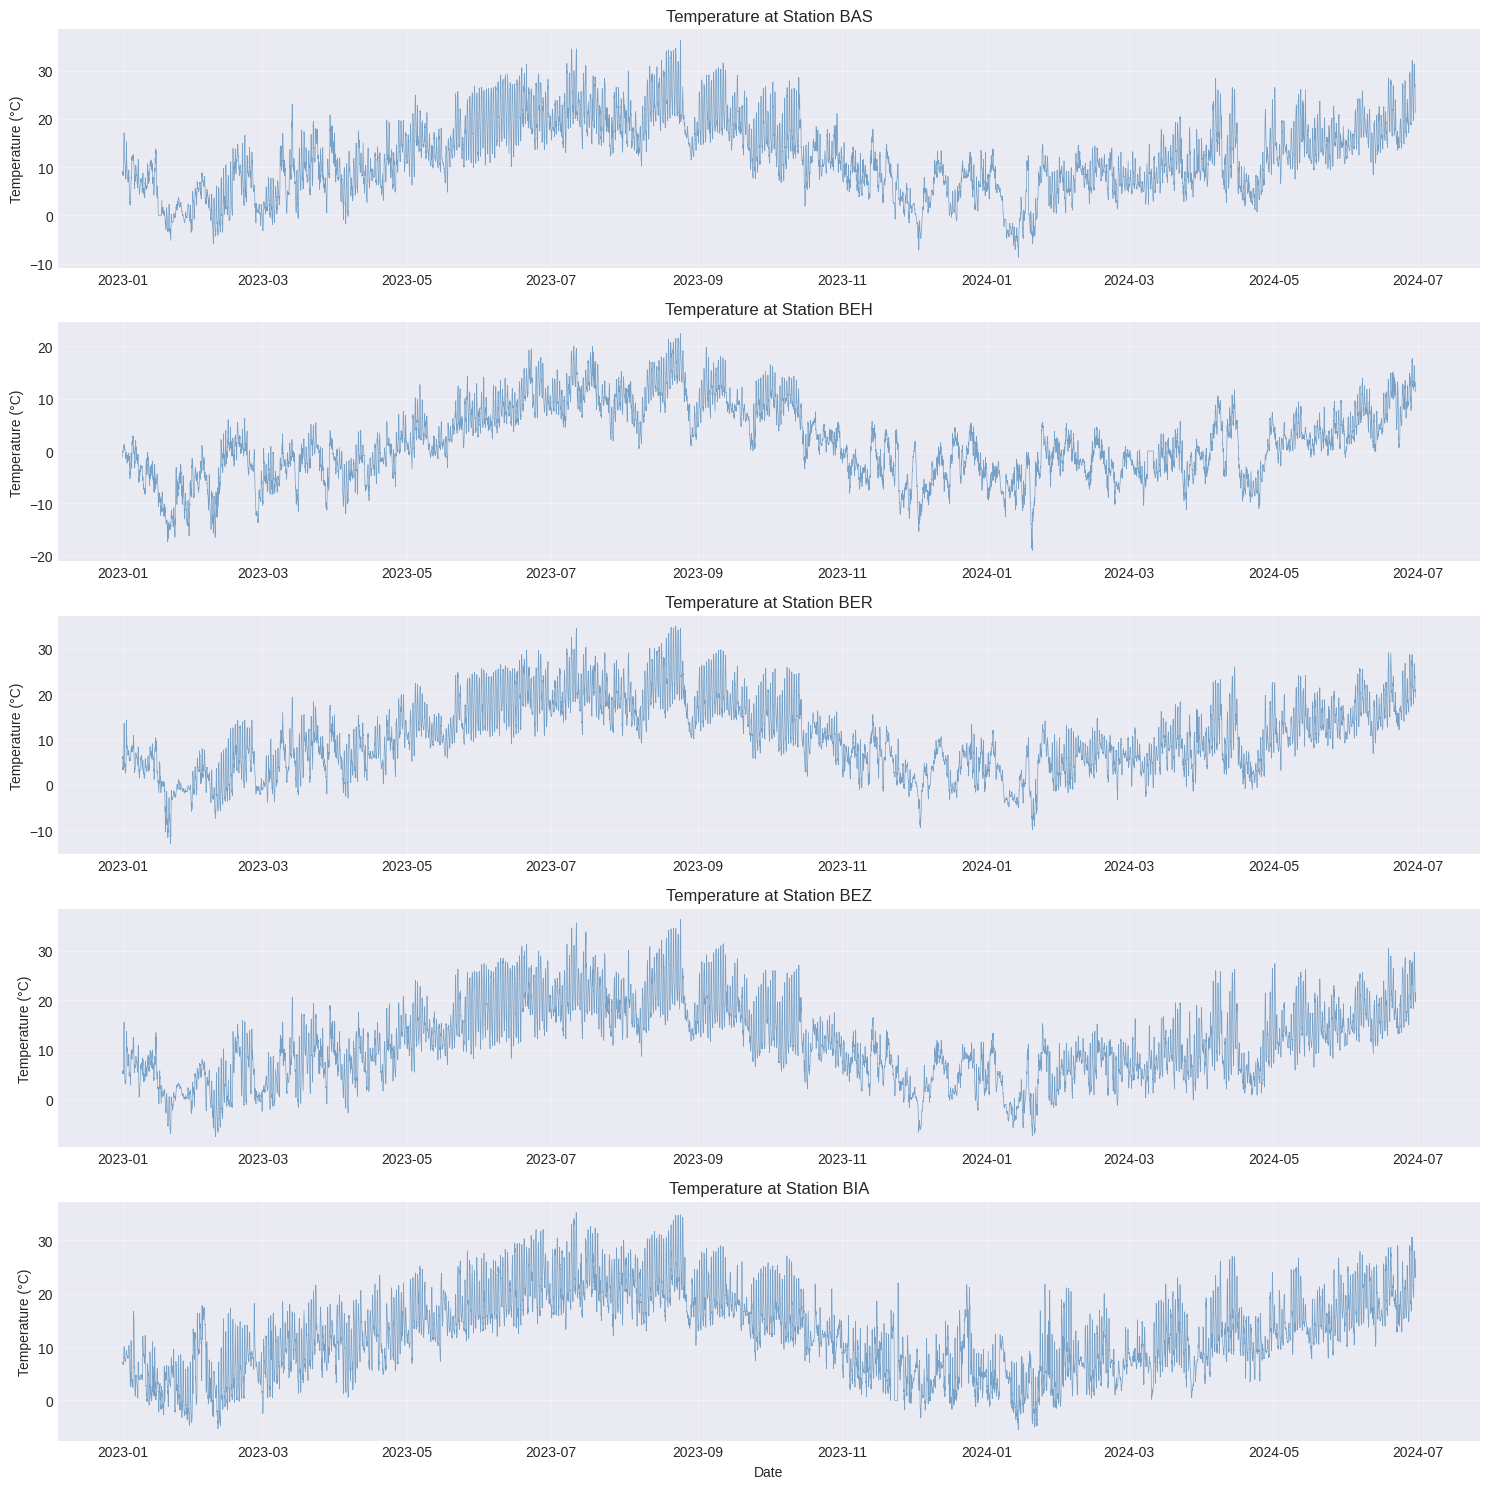

In [ ]:
# %% Plot temperature time series
fig, axes = plt.subplots(len(stations_sample), 1, figsize=(15, 3 * len(stations_sample)))
if len(stations_sample) == 1:
    axes = [axes]

for idx, station in enumerate(stations_sample):
    temp_series = df[station, 'temperature']
    axes[idx].plot(df.index, temp_series, linewidth=0.5, alpha=0.7, color='steelblue')
    axes[idx].set_title(f'Temperature at Station {station}')
    axes[idx].set_ylabel('Temperature (°C)')
    axes[idx].grid(True, alpha=0.3)

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

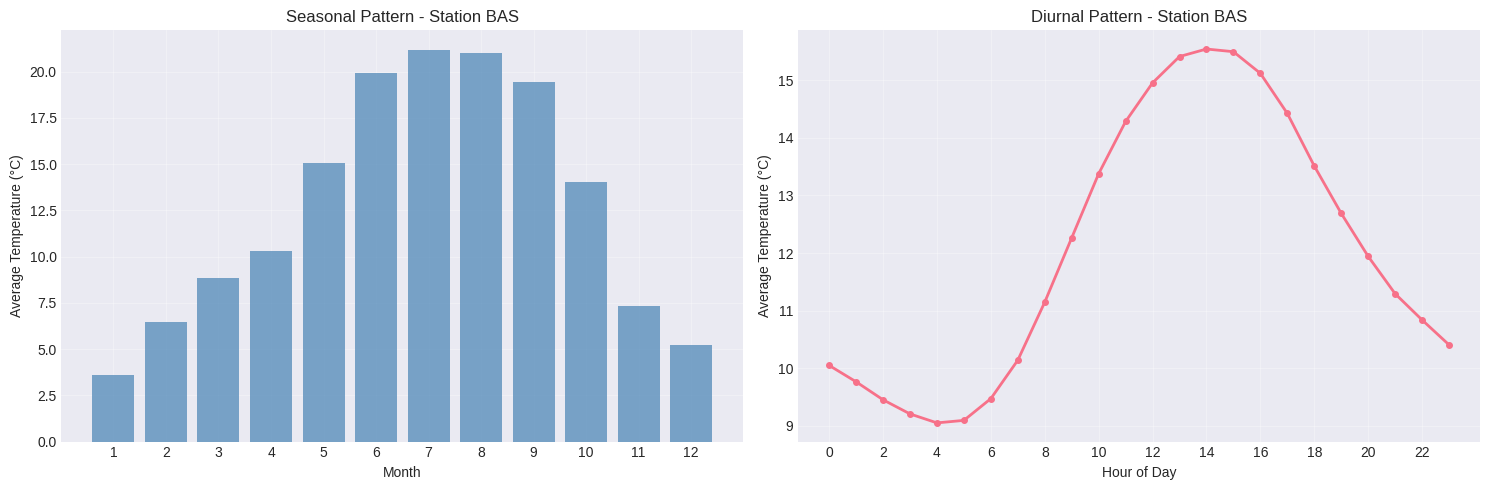

In [ ]:
# Focus on one station with complete data
main_station = stations_sample[0]
temp_series = df[main_station, 'temperature'].dropna()

# Add time features
temp_df = pd.DataFrame({
    'temperature': temp_series,
    'month': temp_series.index.month,
    'hour': temp_series.index.hour,
    'day_of_year': temp_series.index.dayofyear
})

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Monthly pattern
monthly_temp = temp_df.groupby('month')['temperature'].mean()
axes[0].bar(monthly_temp.index, monthly_temp.values, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Average Temperature (°C)')
axes[0].set_title(f'Seasonal Pattern - Station {main_station}')
axes[0].set_xticks(range(1, 13))
axes[0].grid(True, alpha=0.3)

# Hourly pattern
hourly_temp = temp_df.groupby('hour')['temperature'].mean()
axes[1].plot(hourly_temp.index, hourly_temp.values, marker='o', linewidth=2, markersize=4)
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Average Temperature (°C)')
axes[1].set_title(f'Diurnal Pattern - Station {main_station}')
axes[1].set_xticks(range(0, 24, 2))
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


=== Spatial Distribution & Topography ===
Total number of stations: 160

Station elevation (DEM or station_height) statistics:
count     160.000000
mean     1044.635663
std       753.104693
min       203.200000
25%       457.962500
50%       744.100000
75%      1442.140000
max      3571.330000
Name: elevation, dtype: float64


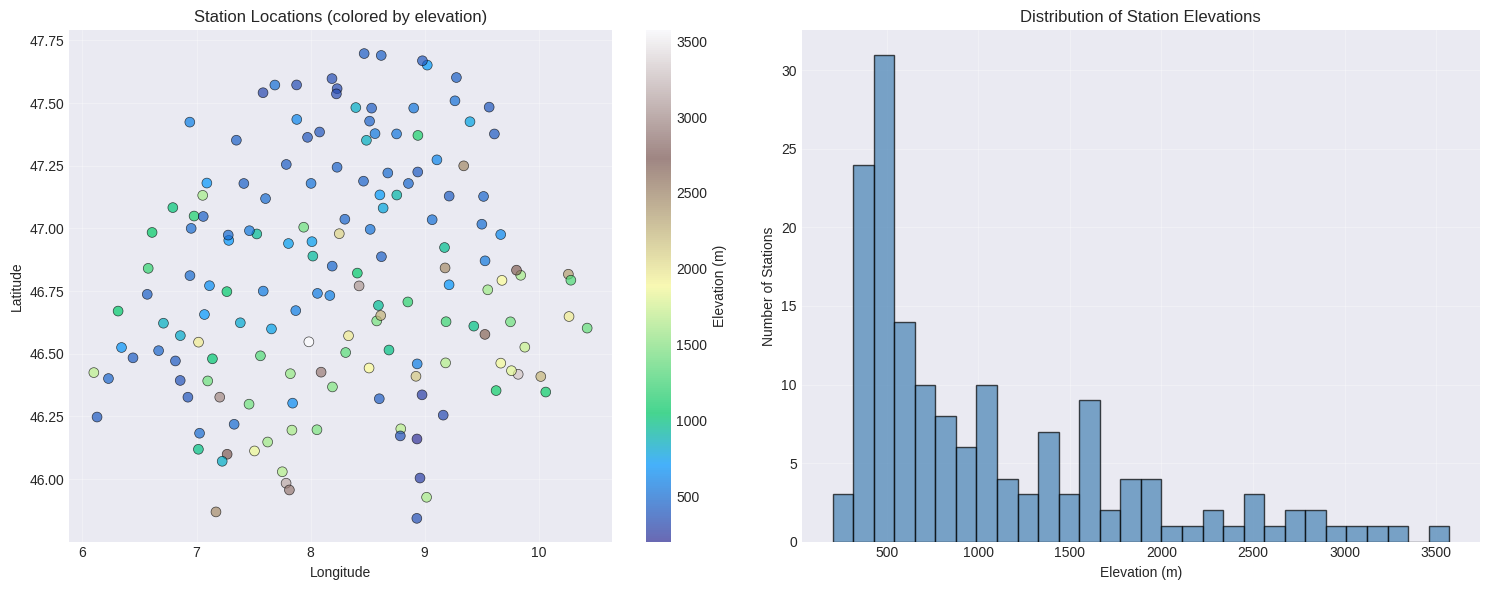

In [74]:
# %% Get station metadata
print(f"\n=== Spatial Distribution & Topography ===")
all_stations = dataset.stations_table.index.tolist()
print(f"Total number of stations: {len(all_stations)}")

# Use stations_table to get latitude and longitude directly
station_df = dataset.stations_table[['latitude', 'longitude']].copy()
station_df["station"] = station_df.index

# Add elevation (DEM if present, fallback to station_height)
if "DEM" in dataset.stations_table.columns:
    station_df["elevation"] = dataset.stations_table["DEM"]
elif "station_height" in dataset.stations_table.columns:
    station_df["elevation"] = dataset.stations_table["station_height"]
else:
    station_df["elevation"] = None

print("\nStation elevation (DEM or station_height) statistics:")
print(station_df['elevation'].describe())


# Plot station locations colored by elevation
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

if 'elevation' in station_df.columns and station_df['elevation'].notna().any():
    scatter = axes[0].scatter(
        station_df['longitude'], station_df['latitude'],
        c=station_df['elevation'], s=50, cmap='terrain',
        edgecolors='black', linewidth=0.5, alpha=0.7
    )
    plt.colorbar(scatter, ax=axes[0], label='Elevation (m)')
else:
    scatter = axes[0].scatter(
        station_df['longitude'], station_df['latitude'],
        s=50, edgecolors='black', linewidth=0.5, alpha=0.7, color='grey'
    )
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title('Station Locations (colored by elevation)')
axes[0].grid(True, alpha=0.3)

# Elevation distribution
if 'elevation' in station_df.columns and station_df['elevation'].notna().any():
    axes[1].hist(station_df['elevation'].dropna(), bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    axes[1].set_xlabel('Elevation (m)')
    axes[1].set_title('Distribution of Station Elevations')
else:
    axes[1].text(0.5, 0.5, 'No elevation data', ha='center', va='center')
axes[1].set_ylabel('Number of Stations')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [54]:
print("\n=== Comprehensive Correlation Analysis ===")
print("Including: Temperature, All Covariates, and Topography Data\n")

# Get all available meteorological parameters for the main station
available_params = dataset.parameters.tolist()
print(f"Available parameters: {available_params}")

# Build correlation dataframe with all meteorological variables
corr_data = {}

# Add all available meteorological parameters
for param in available_params:
    try:
        param_data = df[main_station, param]
        if param_data.notna().sum() > 0:  # Only add if there's data
            corr_data[param] = param_data
    except (KeyError, IndexError):
        print(f"  ✗ Skipped {param}: not available for {main_station}")

# Add temporal features
if len(corr_data) > 0:
    # Use the first available series to get index
    first_series = list(corr_data.values())[0]
    corr_data['month'] = first_series.index.month
    corr_data['day_of_year'] = first_series.index.dayofyear
    corr_data['hour'] = first_series.index.hour
    corr_data['day_of_week'] = first_series.index.dayofweek

# Create DataFrame
corr_df = pd.DataFrame(corr_data, index=first_series.index if corr_data else None)
    

# Drop NaN rows (but keep columns with static topography data)
corr_df_clean = corr_df.dropna(subset=[col for col in corr_df.columns if col not in topo_vars + ['latitude', 'longitude', 'station_height']])

print(f"\n=== Correlation Dataset Summary ===")
print(f"Total features: {len(corr_df_clean.columns)}")
print(f"Features: {list(corr_df_clean.columns)}")
print(f"Time samples: {len(corr_df_clean):,}")
print(f"Date range: {corr_df_clean.index[0]} to {corr_df_clean.index[-1]}")

# Show data types
print(f"\nFeature categories:")
meteo_features = [c for c in corr_df_clean.columns if c in available_params]
temporal_features = [c for c in corr_df_clean.columns if c in ['month', 'hour', 'day_of_year', 'day_of_week']]

print(f"  - Meteorological: {len(meteo_features)} features")
print(f"  - Temporal: {len(temporal_features)} features")


=== Comprehensive Correlation Analysis ===
Including: Temperature, All Covariates, and Topography Data

Available parameters: ['humidity', 'precipitation', 'pressure', 'sunshine', 'temperature', 'wind_direction', 'wind_gust', 'wind_speed', 'wind_u', 'wind_v']

=== Correlation Dataset Summary ===
Total features: 14
Features: ['humidity', 'precipitation', 'pressure', 'sunshine', 'temperature', 'wind_direction', 'wind_gust', 'wind_speed', 'wind_u', 'wind_v', 'month', 'day_of_year', 'hour', 'day_of_week']
Time samples: 13,104
Date range: 2023-01-01 00:00:00+00:00 to 2024-06-29 23:00:00+00:00

Feature categories:
  - Meteorological: 10 features
  - Temporal: 4 features



=== Computing Correlation Matrix ===
Dynamic features (varying over time): 13104

Top 5 features most correlated with temperature:
  humidity                        -0.547  [Meteo]
  sunshine                         0.454  [Meteo]
  month                            0.309  [Temporal]
  day_of_year                      0.307  [Temporal]
  hour                             0.148  [Temporal]

Bottom 5 features least correlated with temperature:
  pressure                         0.056  [Meteo]
  wind_direction                   0.047  [Meteo]
  wind_gust                        0.027  [Meteo]
  day_of_week                      0.014  [Temporal]
  precipitation                   -0.007  [Meteo]

=== Creating Correlation Heatmap ===


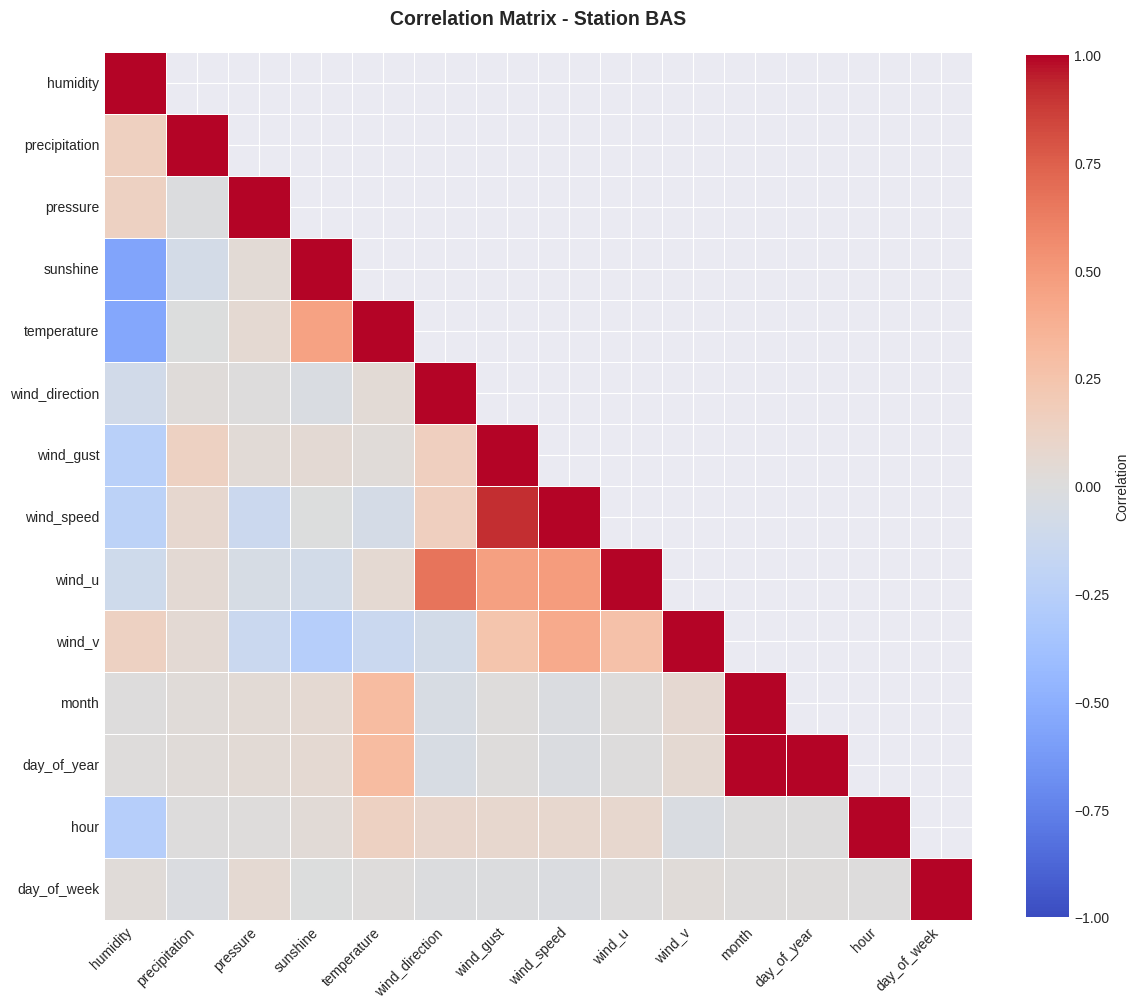

<Figure size 500x500 with 0 Axes>


✓ Correlation matrix saved to: figures/correlation_matrix.png


In [ ]:
# Compute correlation matrix
print("\n=== Computing Correlation Matrix ===")

print(f"Dynamic features (varying over time): {len(corr_df_clean)}")

# Compute correlation matrix only for dynamic features
corr_matrix = corr_df_clean.corr()

# Check for any remaining NaN values
if corr_matrix.isna().any().any():
    nan_cols = corr_matrix.columns[corr_matrix.isna().all()].tolist()
    if nan_cols:
        print(f"Warning: Removing features with NaN correlations (zero variance): {nan_cols}")
        corr_matrix = corr_matrix.drop(columns=nan_cols, index=nan_cols)

# Sort correlations with temperature (excluding temperature itself)
if 'temperature' in corr_matrix.columns:
    temp_correlations = corr_matrix['temperature'].drop('temperature').reindex(
        corr_matrix['temperature'].drop('temperature').abs().sort_values(ascending=False).index
    )
    
    print("\nTop 5 features most correlated with temperature:")
    print("=" * 60)
    for feature, corr_val in temp_correlations.head(5).items():
        feature_type = "Meteo" if feature in meteo_features else ("Temporal" if feature in temporal_features else "Other")
        print(f"  {feature:30s} {corr_val:7.3f}  [{feature_type}]")
    
    print("\nBottom 5 features least correlated with temperature:")
    print("=" * 60)
    for feature, corr_val in temp_correlations.tail(5).items():
        feature_type = "Meteo" if feature in meteo_features else ("Temporal" if feature in temporal_features else "Other")
        print(f"  {feature:30s} {corr_val:7.3f}  [{feature_type}]")
    

# Create comprehensive correlation heatmap
print("\n=== Creating Correlation Heatmap ===")

# Group features for better visualization
feature_groups = {
    'Meteorological': meteo_features,
    'Temporal': temporal_features,
}

# Reorder columns for better visualization
ordered_cols = []
for group_name, features in feature_groups.items():
    ordered_cols.extend([f for f in features if f in corr_matrix.columns])


# Reorder correlation matrix
corr_matrix_ordered = corr_matrix.loc[ordered_cols, ordered_cols]

# Create figure with appropriate size based on number of features
n_features = len(corr_matrix_ordered)
fig_size = max(14, n_features * 0.5)

fig, ax = plt.subplots(figsize=(fig_size, fig_size))

# Create heatmap - show only lower triangle
mask = np.triu(np.ones_like(corr_matrix_ordered, dtype=bool), k=1)  # Mask upper triangle
sns.heatmap(
    corr_matrix_ordered, 
    annot=False,  # Don't annotate all cells (too many)
    fmt='.2f', 
    cmap='coolwarm', 
    center=0,
    square=True, 
    linewidths=0.5, 
    cbar_kws={"shrink": 0.8, "label": "Correlation"},
    mask=mask,  # Show only lower triangle
    ax=ax,
    vmin=-1, vmax=1
)
            

ax.set_title(f'Correlation Matrix - Station {main_station}', 
             fontsize=14, fontweight='bold', pad=20)

# Rotate labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.figure(figsize=(5, 5))
plt.tight_layout()
plt.show()

print(f"\n✓ Correlation matrix saved to: figures/correlation_matrix.png")

